In [1]:
import healpy as hp
import numpy as np
import pandas as pd
from healpy.newvisufunc import projview, newprojplot
import matplotlib.pyplot as plt

In [2]:
# Sample of master data file, sliced and filtered for distance between 400-600 pc.
master = pd.read_csv("400-600pc_distance_filtered_sample.csv")
master

Unnamed: 0          ra        dec       pmra      pmdec  \
0                0   44.927666   0.219128  11.987892  -8.529984   
1                8   45.488387   0.454092   5.465042  -5.667156   
2               11   45.517794   0.585769  13.976403  -8.813262   
3               12   45.676892   0.602907  20.993286  10.382061   
4               19   44.645347   0.307106  11.049029 -10.403697   
...            ...         ...        ...        ...        ...   
788368     2999991  312.625129 -83.062297  40.498265 -29.129386   
788369     2999992  314.730957 -83.334881  -2.960465  -3.233746   
788370     2999993  314.215831 -83.205262 -28.996328  14.759030   
788371     2999996  315.877177 -83.175296  -7.858968 -29.768070   
788372     2999997  316.410578 -83.087336 -14.504928  -0.991429   

        r_med_photogeo  radial_velocity  
0            593.35390          0.00000  
1            462.71440          0.00000  
2            539.78220          0.00000  
3            555.50450          0.00000  
4            465.51035          0.00000  
...                ...              ...  
788368       442.06055          0.00000  
788369       545.33966          0.00000  
788370       447.54297         79.57785  
788371       474.13030          0.00000  
788372       493.52500          0.00000  

[788373 rows x 7 columns]

In [3]:
# Functions, directly from healpy, that healbin uses to help in creating the healbins for the map pixels.
def _ra_dec2_hpid(nside, ra, dec, **kwargs):
    """
    Assign ra,dec points to the correct healpixel.

    Parameters
    ----------
    nside : int
        Must be a value of 2^N.
    ra : np.array
        RA values to assign to healpixels. Radians.
    dec : np.array
        Dec values to assign to healpixels. Radians.

    Returns
    -------
    hpids : np.array
        Healpixel IDs for the input positions.
    """
    lat = np.pi / 2.0 - dec
    hpids = hp.ang2pix(nside, lat, ra, **kwargs)
    return hpids


def ra_dec2_hpid(nside, ra, dec, **kwargs):
    """
    Assign ra,dec points to the correct healpixel.

    Parameters
    ----------
    nside : int
        Must be a value of 2^N.
    ra : np.array
        RA values to assign to healpixels. Degrees.
    dec : np.array
        Dec values to assign to healpixels. Degrees.

    Returns
    -------
    hpids : np.array
        Healpixel IDs for the input positions.
    """
    return _ra_dec2_hpid(nside, np.radians(ra), np.radians(dec), **kwargs)

In [4]:
# Functions, directly from healpy, for creating the healbins for the map pixels using mean as the applied function.
def _healbin(ra, dec, values, nside=128, reduce_func=np.mean, dtype=float, fill_val=hp.UNSEEN):
    """
    Take arrays of ra's, dec's, and value and bin into healpixels. Like numpy.hexbin but for
    bins on a sphere.

    Parameters
    ----------
    ra : np.array
        RA positions of the data points. Radians.
    dec : np.array
        Dec positions of the data points. Radians
    values : np.array
        The values at each ra,dec position.
    nside : int
        Healpixel nside resolution. Must be a value of 2^N.
    reduce_func : function (numpy.mean)
        A function that will return a single value given a subset of `values`.
    dtype : dtype ('float')
        Data type of the resulting mask
    fill_val : float (hp.UNSEEN)
        Value to fill in with healpixels that have no value.
        Default is the healpy mask value.

    Returns
    -------
    map_vals : np.array
        A numpy array that is a valid Healpixel map.
    """

    hpids = _ra_dec2_hpid(nside, ra, dec)

    order = np.argsort(hpids)
    hpids = hpids[order]
    values = values[order]
    pixids = np.unique(hpids)

    left = np.searchsorted(hpids, pixids)
    right = np.searchsorted(hpids, pixids, side="right")

    map_vals = np.zeros(hp.nside2npix(nside), dtype=dtype) + fill_val

    # Wow, I thought histogram would be faster than the loop, but this has been faster!
    for i, idx in enumerate(pixids):
        map_vals[idx] = reduce_func(values[left[i] : right[i]])

    # Change any NaNs to fill value
    map_vals[np.isnan(map_vals)] = fill_val

    return map_vals



def healbin(ra, dec, values, nside=128, reduce_func=np.mean, dtype=float, fill_val=hp.UNSEEN):
    """
    Take arrays of ra's, dec's, and value and bin into healpixels. Like numpy.hexbin but for
    bins on a sphere.

    Parameters
    ----------
    ra : np.array
        RA positions of the data points. Degrees.
    dec : np.array
        Dec positions of the data points. Degrees.
    values : np.array
        The values at each ra,dec position.
    nside : int
        Healpixel nside resolution. Must be a value of 2^N.
    reduce_func : function (numpy.mean)
        A function that will return a single value given a subset of `values`.
    dtype : dtype ('float')
        Data type of the resulting mask
    fill_val : float (hp.UNSEEN)
        Value to fill in with healpixels that have no value.
        Default is the healpy mask value.

    Returns
    -------
    mapVals : np.array
        A numpy array that is a valid Healpixel map.
    """
    return _healbin(
        np.radians(ra),
        np.radians(dec),
        values,
        nside=nside,
        reduce_func=reduce_func,
        dtype=dtype,
        fill_val=fill_val,
    )

In [5]:
# Functions for creating the healbins for the map pixels, but now using rms as the applied function.
def rms(values):
    RMS = np.sqrt(np.mean(values ** 2))

    return RMS



def _healbin2(ra, dec, values, nside=128, reduce_func=rms, dtype=float, fill_val=hp.UNSEEN):
    """
    Take arrays of ra's, dec's, and value and bin into healpixels. Like numpy.hexbin but for
    bins on a sphere.

    Parameters
    ----------
    ra : np.array
        RA positions of the data points. Radians.
    dec : np.array
        Dec positions of the data points. Radians
    values : np.array
        The values at each ra,dec position.
    nside : int
        Healpixel nside resolution. Must be a value of 2^N.
    reduce_func : function (numpy.mean)
        A function that will return a single value given a subset of `values`.
    dtype : dtype ('float')
        Data type of the resulting mask
    fill_val : float (hp.UNSEEN)
        Value to fill in with healpixels that have no value.
        Default is the healpy mask value.

    Returns
    -------
    map_vals : np.array
        A numpy array that is a valid Healpixel map.
    """

    hpids = _ra_dec2_hpid(nside, ra, dec)

    order = np.argsort(hpids)
    hpids = hpids[order]
    values = values[order]
    pixids = np.unique(hpids)

    left = np.searchsorted(hpids, pixids)
    right = np.searchsorted(hpids, pixids, side="right")

    map_vals = np.zeros(hp.nside2npix(nside), dtype=dtype) + fill_val

    # Wow, I thought histogram would be faster than the loop, but this has been faster!
    for i, idx in enumerate(pixids):
        map_vals[idx] = reduce_func(values[left[i] : right[i]])

    # Change any NaNs to fill value
    map_vals[np.isnan(map_vals)] = fill_val

    return map_vals


def healbin2(ra, dec, values, nside=128, reduce_func=rms, dtype=float, fill_val=hp.UNSEEN):
    """
    Take arrays of ra's, dec's, and value and bin into healpixels. Like numpy.hexbin but for
    bins on a sphere.

    Parameters
    ----------
    ra : np.array
        RA positions of the data points. Degrees.
    dec : np.array
        Dec positions of the data points. Degrees.
    values : np.array
        The values at each ra,dec position.
    nside : int
        Healpixel nside resolution. Must be a value of 2^N.
    reduce_func : function (numpy.mean)
        A function that will return a single value given a subset of `values`.
    dtype : dtype ('float')
        Data type of the resulting mask
    fill_val : float (hp.UNSEEN)
        Value to fill in with healpixels that have no value.
        Default is the healpy mask value.

    Returns
    -------
    mapVals : np.array
        A numpy array that is a valid Healpixel map.
    """
    return _healbin2(
        np.radians(ra),
        np.radians(dec),
        values,
        nside=nside,
        reduce_func=reduce_func,
        dtype=dtype,
        fill_val=fill_val,
    )

In [6]:
# Creating the bins to be used for mapping.
pmra_bin_mean = healbin(master['ra'], master['dec'], master['pmra'])
pmdec_bin_mean = healbin(master['ra'], master['dec'], master['pmdec'])
rad_vel_bin_mean = healbin(master['ra'], master['dec'], master['radial_velocity'])

pmra_bin_rms = healbin2(master['ra'], master['dec'], master['pmra'])
pmdec_bin_rms = healbin2(master['ra'], master['dec'], master['pmdec'])
rad_vel_bin_rms = healbin2(master['ra'], master['dec'], master['radial_velocity'])

In [7]:
# Masking
pmra_bin_mean_mask = hp.ma(pmra_bin_mean)
pmdec_bin_mean_mask = hp.ma(pmdec_bin_mean)
rad_vel_bin_mean_mask = hp.ma(rad_vel_bin_mean)

pmra_bin_rms_mask = hp.ma(pmra_bin_rms)
pmdec_bin_rms_mask = hp.ma(pmdec_bin_rms)
rad_vel_bin_rms_mask = hp.ma(rad_vel_bin_rms)

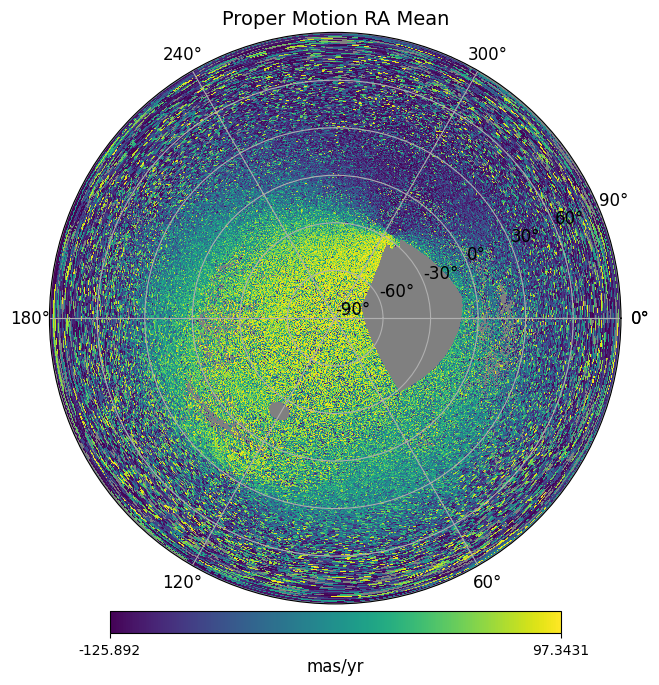

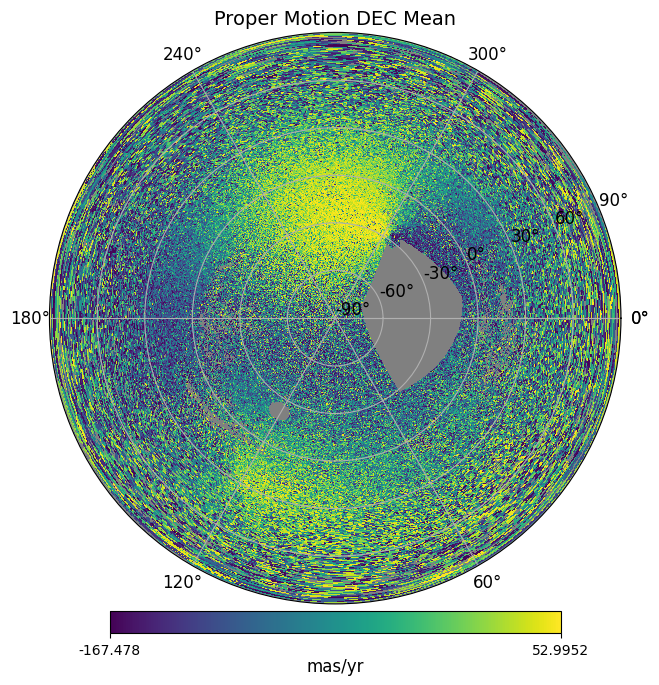

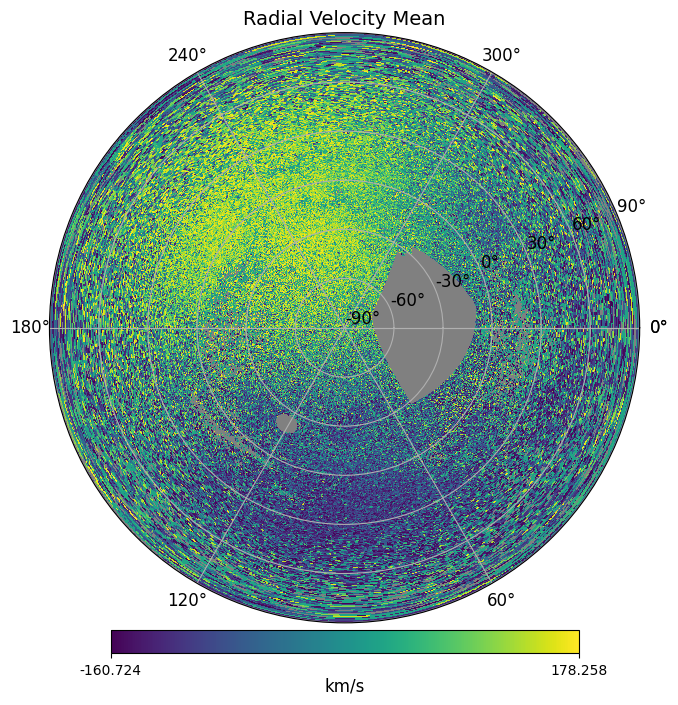

In [43]:
# Healpy polar plots for pmra, pmdec, and radial velocity using mean as applied function. Also, has rotation applied from celestial to galactic coordinates.
projview(pmra_bin_mean_mask, norm='hist', graticule=True, graticule_labels=True, projection_type="polar", title ="Proper Motion RA Mean", coord=['C', 'G'], unit="mas/yr");

projview(pmdec_bin_mean_mask, norm='hist', graticule=True, graticule_labels=True, projection_type="polar", title ="Proper Motion DEC Mean", coord=['C', 'G'], unit="mas/yr");


projview(rad_vel_bin_mean_mask, norm='hist', graticule=True, graticule_labels=True, projection_type="polar", title ="Radial Velocity Mean", coord=['C', 'G'], unit="km/s");

plt.tight_layout();

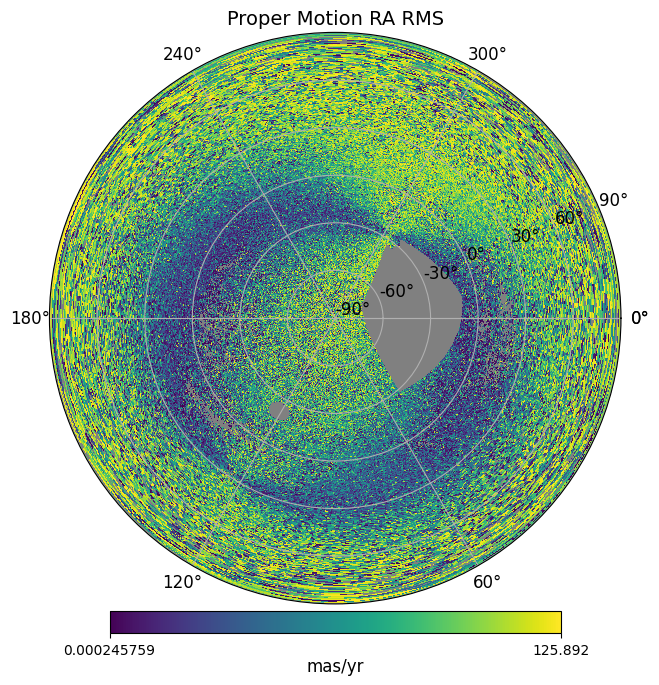

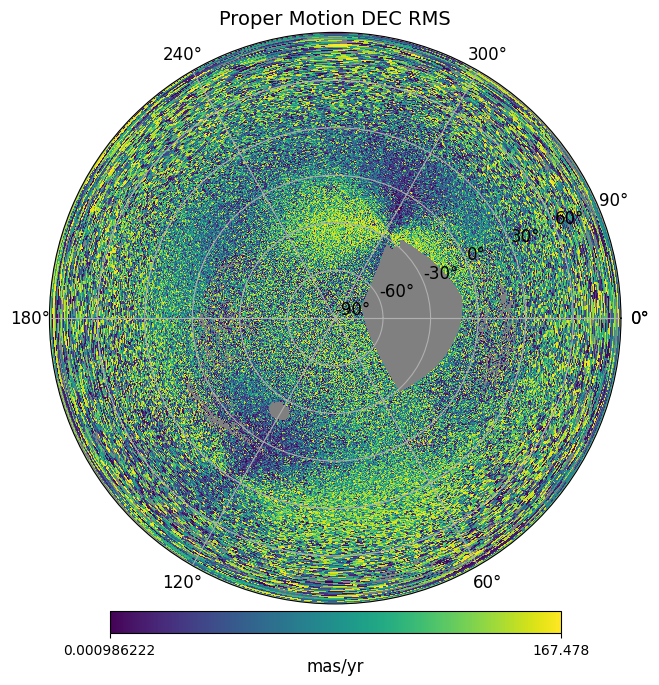

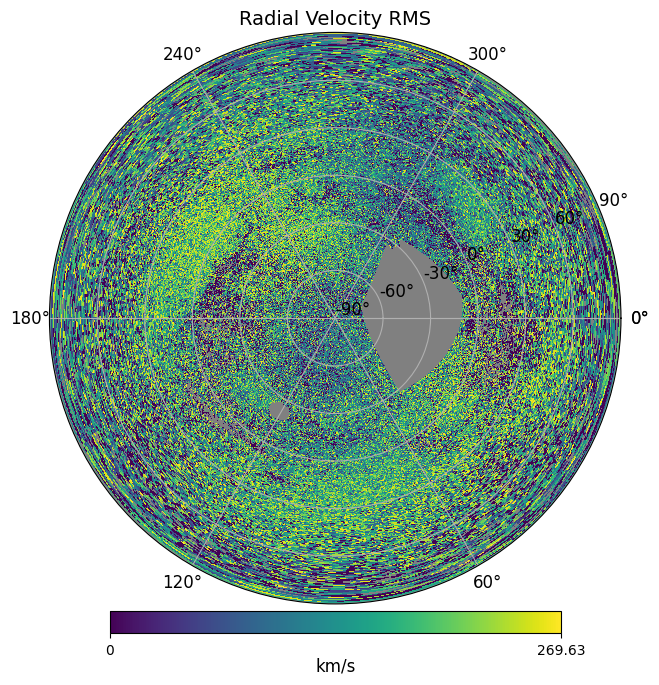

In [42]:
# Healpy polar plots for pmra, pmdec, and radial velocity using rms as applied function. Also, has rotation applied from celestial to galactic coordinates.
projview(pmra_bin_rms_mask, norm='hist', graticule=True, graticule_labels=True, projection_type="polar", title ="Proper Motion RA RMS", coord=['C', 'G'], unit="mas/yr")

projview(pmdec_bin_rms_mask, norm='hist', graticule=True, graticule_labels=True, projection_type="polar", title ="Proper Motion DEC RMS", coord=['C', 'G'], unit="mas/yr")

projview(rad_vel_bin_rms_mask, norm='hist', graticule=True, graticule_labels=True, projection_type="polar", title ="Radial Velocity RMS", coord=['C', 'G'], unit="km/s")